In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.datasets import mnist

from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout

from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

tf.config.list_physical_devices('GPU')

%matplotlib inline

## Data preprocessing

After importing the MNIST handwritten digits dataset, it is split into training, validation, and testing datasets.
The x-values are reshaped to follow the Keras/Tensorflow *channels_last* data format, and normalized to be in the range 0-1,
for improved model training.
The y-values are one-hot encoded to ensure that all classes have the same importance to the model during training.

As the model is trained on the MNIST dataset, only the testing part of the AddNIST dataset is selected.
The x-values are first split by color channel into red, green, and blue, and then preprocessed the same way as the training data. The y-values are not one-hot encoded, because they are later used to generate the classification report.

In [2]:
def preprocess_x(x):
    
    x = x.reshape(x.shape[0], 28, 28, 1)
    processed_x = (x - x.min())/x.ptp().astype('float32')
    return processed_x

def preprocess_y(y, categories):
    
    processed_y = to_categorical(y, categories)
    
    return processed_y

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=0.2, random_state= 8)

x_train = preprocess_x(x_train)
x_val = preprocess_x(x_val)
x_test = preprocess_x(x_test)

y_train = preprocess_y(y_train, 10)
y_val = preprocess_y(y_val, 10)
y_test = preprocess_y(y_test, 10)

In [4]:
AddNIST_x_test = np.load("test_x.npy", allow_pickle=True)
AddNIST_y_test = np.load("test_y.npy", allow_pickle=True)

r = AddNIST_x_test[:,0]
r = preprocess_x(r)

g = AddNIST_x_test[:,1]
g = preprocess_x(g)

b = AddNIST_x_test[:,2]
b = preprocess_x(b)

## Building, compiling, and training the model

The model is a convolutional neural network, with a single convolution layer for feature extraction. After extraction, the feature map is downsampled using max pooling, and flattened into a one-dimensional input tensor. Batch normalization is applied to stabilize training and reduce the number of epochs required to train the neural network. 
The flattened and normalized output is then passed into the first fully connected feature selection layer, with a ReLU activation function to avoid the vanishing gradient problem. A dropout layer is added between the two feature selection layers to prevent overfitting. For multi-class classification, the softmax activation function suits best and is used in the final dense layer to produce the model’s prediction.

Compiling the model, I chose stochastic gradient descent with a learning rate of 0.01, and 0.9 momentum, as it yielded slightly higher accuracy than the Adam optimizer. Converting the data labels to one-hot encoding and using the categorical cross-entropy loss function also yielded the best results, when compared to spare categorical cross-entropy and Kullback Leibler divergence loss. When training the model, I chose the number of epochs and batch size that provided the fastest training speed, without sacrificing accuracy.

In [5]:
initializer = he_normal(seed=32)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer, input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))


model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu', kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, 
               loss='categorical_crossentropy', 
                metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5408)              21632     
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [13]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val), verbose=1)

Epoch 1/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0112 - accuracy: 0.9963 - val_loss: 0.0609 - val_accuracy: 0.9862
Epoch 2/10
 646/1500 [===========>..................] - ETA: 7s - loss: 0.0102 - accuracy: 0.9965

KeyboardInterrupt: 

## Evaluating the model

The model achieved 99% accuracy while training, 98% accuracy on the validation dataset, and 97% accuracy on the AddNIST testing dataset.
To get the final prediction, the model was used to make a prediction on each of the three colour channels. The predictions were then manually summed together and subtracted 1, which lead to some outliers. As some digits were misclassified, the final prediction had values less than 0 and larger than 19, which was accounted for by reducing those anomalies to fit within the range 0-19.

In [7]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0434 - accuracy: 0.9869


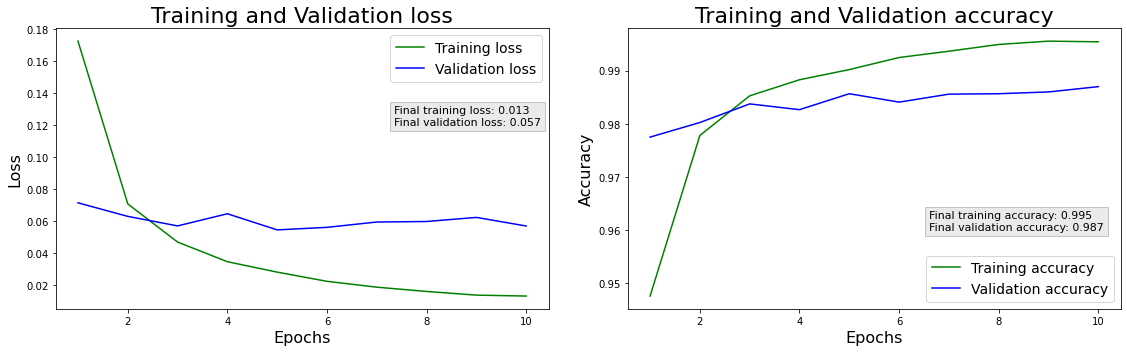

In [8]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


fig, (ax1,ax2) = plt.subplots(1, 2) 
fig.set_size_inches(16, 5)
epochs = range(1,11)

ax1.plot(epochs, train_loss, 'g', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and Validation loss', fontsize = 22)
ax1.set_xlabel('Epochs', fontsize = 16)
ax1.set_ylabel('Loss', fontsize = 16)
ax1.legend(fontsize = 14)

ax2.plot(epochs, train_accuracy, 'g', label='Training accuracy')
ax2.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax2.set_title('Training and Validation accuracy', fontsize = 22)
ax2.set_xlabel('Epochs', fontsize = 16)
ax2.set_ylabel('Accuracy', fontsize = 16)
ax2.legend(fontsize = 14)

f_loss = [train_loss[-1], val_loss[-1]]
final_loss = "Final training loss: {}\nFinal validation loss: {}".format(round(f_loss[0], 3), round(f_loss[1], 3))

ax1.text(7.35, 0.12, final_loss, fontsize = 11, 
         bbox = dict(facecolor = '#969696', alpha = 0.2))

f_acc = [train_accuracy[-1], val_accuracy[-1]]
final_accuracy = "Final training accuracy: {}\nFinal validation accuracy: {}".format(round(f_acc[0], 3), round(f_acc[1], 3))

ax2.text(6.6, 0.96, final_accuracy, fontsize = 11, 
         bbox = dict(facecolor = '#969696', alpha = 0.2))


plt.tight_layout()
plt.savefig('Part 1 Training and Validation loss and accuracy.png', dpi=200, format='png', bbox_inches='tight')

In [9]:
r_pred = model.predict(r)
g_pred = model.predict(g)
b_pred = model.predict(b)

final_pred = []

for i in range(len(r_pred)):
    
    final_pred.append(np.argmax(r_pred[i]) + np.argmax(g_pred[i]) + np.argmax(b_pred[i]) - 1)
    
    if final_pred[i] > 19:
        #print("More than 20: ", final_pred[i], "i: ", i, "r, g, b: ", np.argmax(r_pred[i]), np.argmax(g_pred[i]), np.argmax(b_pred[i]))
        final_pred[i] = 19    
        
    elif final_pred[i] < 0:
        #print("Less than 0: ", final_pred[i], "i: ", i, "r, g, b: ", np.argmax(r_pred[i]), np.argmax(g_pred[i]), np.argmax(b_pred[i]))
        final_pred[i] = 0

final_pred = np.asarray(final_pred)

In [10]:
'''
Plotting scikit-learn classification report as a heatmap
Source: https://stackoverflow.com/questions/28200786/ 
By Franck Dernoncourt
'''

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(figure_width, figure_height)



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 12
    figure_height = 18
    correct_orientation = True
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

[1.0, 0.99, 0.99]
[1.0, 0.98, 0.99]
[0.99, 0.97, 0.98]
[0.98, 0.98, 0.98]
[0.98, 0.98, 0.98]
[0.98, 0.97, 0.97]
[0.97, 0.99, 0.98]
[0.96, 0.97, 0.96]
[0.95, 0.97, 0.96]
[0.97, 0.98, 0.97]
[0.95, 0.96, 0.96]
[0.95, 0.97, 0.96]
[0.94, 0.97, 0.96]
[0.95, 0.94, 0.95]
[0.95, 0.97, 0.96]
[0.96, 0.96, 0.96]
[0.96, 0.97, 0.97]
[0.97, 0.94, 0.95]
[0.98, 0.94, 0.96]
[0.95, 0.95, 0.95]
plotMat: [[1.0, 0.99, 0.99], [1.0, 0.98, 0.99], [0.99, 0.97, 0.98], [0.98, 0.98, 0.98], [0.98, 0.98, 0.98], [0.98, 0.97, 0.97], [0.97, 0.99, 0.98], [0.96, 0.97, 0.96], [0.95, 0.97, 0.96], [0.97, 0.98, 0.97], [0.95, 0.96, 0.96], [0.95, 0.97, 0.96], [0.94, 0.97, 0.96], [0.95, 0.94, 0.95], [0.95, 0.97, 0.96], [0.96, 0.96, 0.96], [0.96, 0.97, 0.97], [0.97, 0.94, 0.95], [0.98, 0.94, 0.96], [0.95, 0.95, 0.95]]
support: [395, 423, 454, 504, 447, 544, 497, 466, 527, 534, 531, 544, 536, 506, 519, 507, 477, 518, 532, 539]


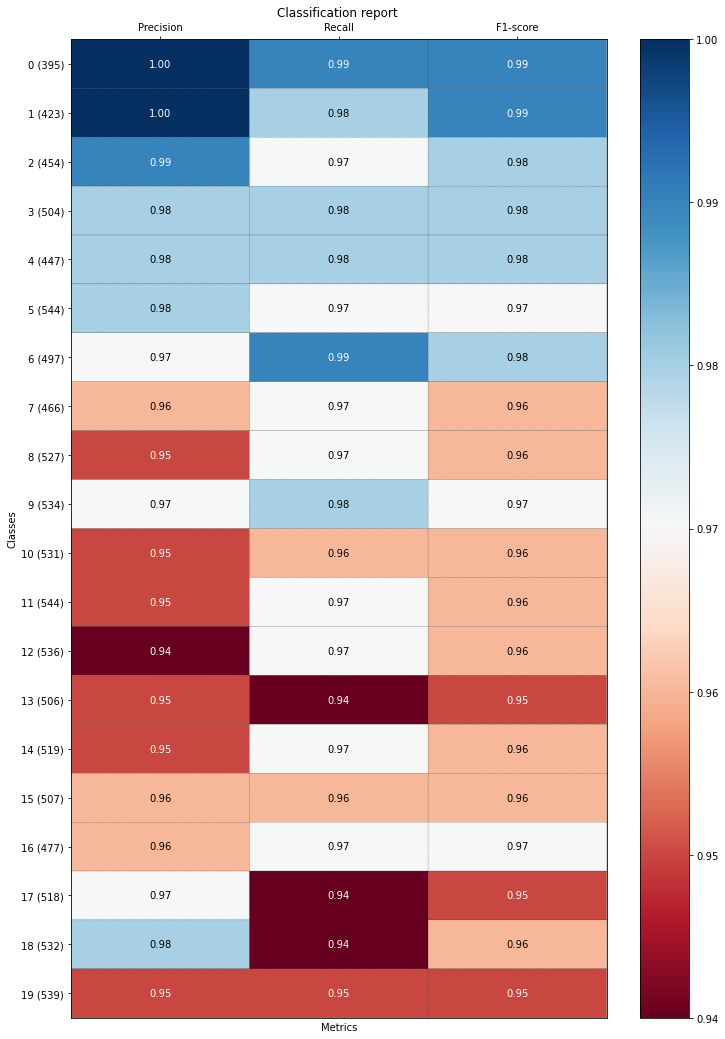

In [11]:
report = classification_report(AddNIST_y_test, final_pred)
plot_classification_report(report)
plt.savefig('Part 1 Classification Report.png', dpi=200, format='png', bbox_inches='tight')

In [12]:
print(report)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       395
           1       1.00      0.98      0.99       423
           2       0.99      0.97      0.98       454
           3       0.98      0.98      0.98       504
           4       0.98      0.98      0.98       447
           5       0.98      0.97      0.97       544
           6       0.97      0.99      0.98       497
           7       0.96      0.97      0.96       466
           8       0.95      0.97      0.96       527
           9       0.97      0.98      0.97       534
          10       0.95      0.96      0.96       531
          11       0.95      0.97      0.96       544
          12       0.94      0.97      0.96       536
          13       0.95      0.94      0.95       506
          14       0.95      0.97      0.96       519
          15       0.96      0.96      0.96       507
          16       0.96      0.97      0.97       477
          17       0.97    